# Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the Data

The planet dataset isn't available on the fastai dataset page due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal. Depending on your environment, you may need to append "--user" to the command.

In [ ]:
# ! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands.

In [9]:
# ! mkdir -p .kaggle/
! mv kaggle.json .kaggle/

You're all set to download the data from planet competition. You just need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data).

In [7]:
path = Path('data/planet')
os.makedirs(path, exist_ok=True)
path

PosixPath('data/planet')

In [12]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip {path}/train_v2.csv.zip -d {path}

100%|███████████████████████████████████████▉| 600M/600M [03:50<00:00, 2.93MB/s]
100%|████████████████████████████████████████| 600M/600M [03:50<00:00, 2.73MB/s]
100%|█████████████████████████████████████████| 159k/159k [00:00<00:00, 915kB/s]

Archive:  data/planet/train_v2.csv.zip
  inflating: data/planet/train_v2.csv  
   creating: data/planet/__MACOSX/
  inflating: data/planet/__MACOSX/._train_v2.csv  


We only download the training data file for this lesson, but you can grab the test file if you want to make a late submission.

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it.

In [13]:
# ! sudo apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package p7zip-full


In [14]:
# ! 7za -bd -y x {path}/train-jpg.tar.7z -o{path}
# ! tar -xf {path}/train-jpg.tar -C {path}


7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=C.UTF-8,Utf16=on,HugeFiles=on,16 CPUs)

Processing archive: data/planet/train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207


In [16]:
path.ls()

[PosixPath('data/planet/train-jpg.tar'),
 PosixPath('data/planet/__MACOSX'),
 PosixPath('data/planet/train-jpg.tar.7z'),
 PosixPath('data/planet/train-jpg'),
 PosixPath('data/planet/train_v2.csv.zip'),
 PosixPath('data/planet/train_v2.csv')]

In [30]:
# get the test as well
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y x {path}/test-jpg.tar.7z -o{path}
! tar -xf {path}/test-jpg.tar -C {path}

100%|███████████████████████████████████████▉| 603M/603M [03:58<00:00, 2.70MB/s]
100%|████████████████████████████████████████| 603M/603M [03:58<00:00, 2.65MB/s]

7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=C.UTF-8,Utf16=on,HugeFiles=on,16 CPUs)

Processing archive: data/planet/test-jpg.tar.7z

Extracting  test-jpg.tar

Everything is Ok

Size:       668989440
Compressed: 632362315


# Multiclass classification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [17]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road



To put this in a DataBunch while using the data block API, we then need to using ImageMultiDataset (and not ImageClassificationDataset). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [18]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [19]:
np.random.seed()
data = (ImageFileList.from_folder(path)            
        .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')  
        .random_split_by_pct(0.2)
        .datasets(ImageMultiDataset)  
        .transform(tfms, size=128)             
        .databunch()
        .normalize(imagenet_stats))

show_batch still works, and show us the different labels separated by ;.

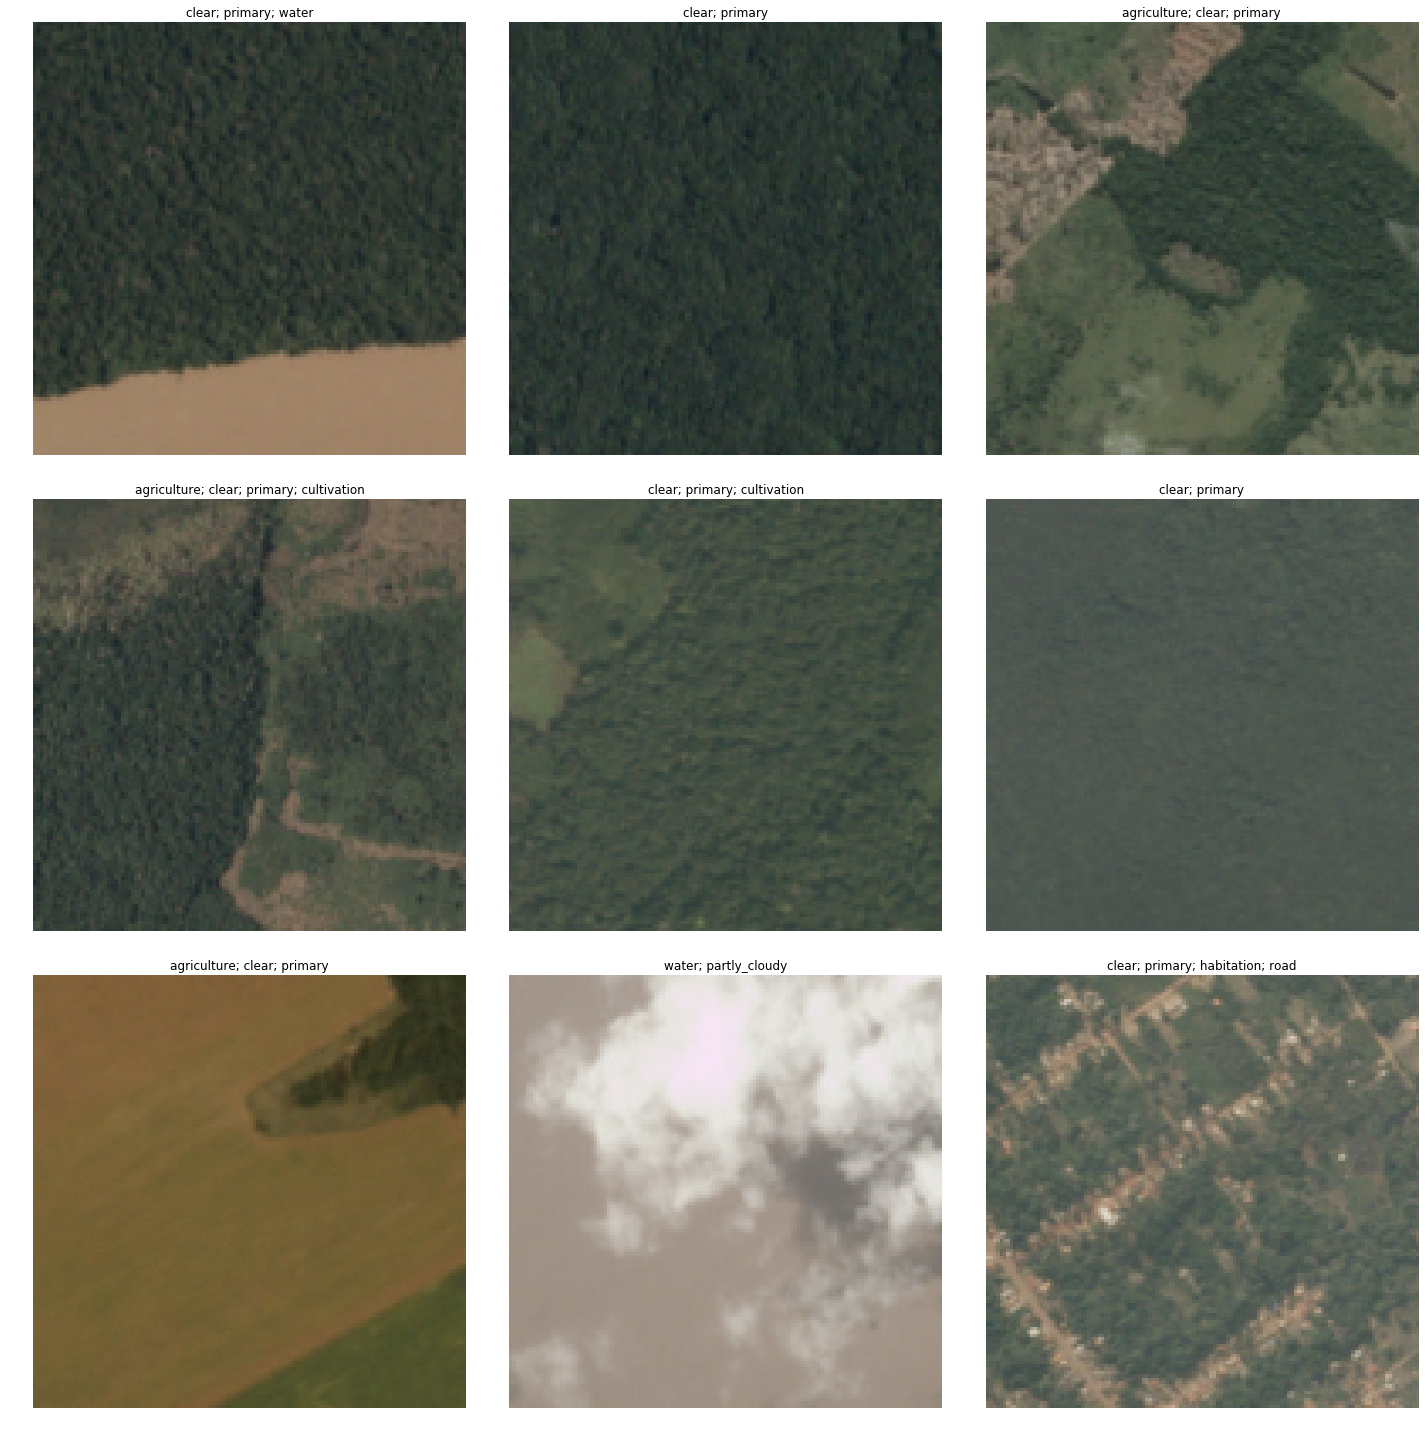

In [22]:
data.show_batch(rows=3, figsize=(20,20))

To create a Learner we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the one that are above a certain threshold (0.5 by default) and comapre them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See here for more details.

In [23]:
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet34, metrics=[accuracy_thresh, f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:15<00:00, 5803849.80it/s]


We use the LR Finder to pick a good learning rate.



In [24]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


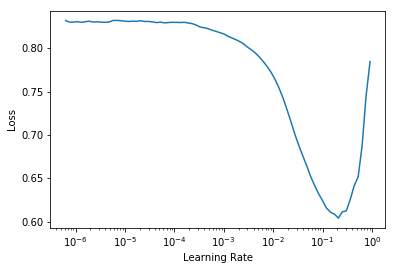

In [25]:
learn.recorder.plot()

In [26]:
lr = 0.1

In [27]:
learn.fit_one_cycle(5, lr)

Total time: 03:53
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.177320    0.185923    0.937311         0.849759  (00:46)
2      0.184915    9.919868    0.885260         0.726267  (00:47)
3      0.155761    0.161918    0.952171         0.890639  (00:46)
4      0.122618    0.280502    0.958021         0.906724  (00:46)
5      0.111002    0.999937    0.960666         0.914675  (00:46)



In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5, slice(lr/100, lr/5))

Total time: 05:28
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.131167    0.154421    0.939462         0.859205  (01:05)
2      0.130735    0.139765    0.948334         0.870697  (01:05)
3      0.113573    0.110224    0.959728         0.908026  (01:05)
4      0.106927    0.097032    0.963383         0.920326  (01:05)
5      0.099430    0.090027    0.965055         0.922996  (01:05)



In [31]:
learn.save('stage-2')

# Prediction on test

In [32]:
learn.load('stage-2')

In [35]:
data.classes

['agriculture',
 'clear',
 'primary',
 'water',
 'habitation',
 'road',
 'haze',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'cultivation',
 'bare_ground',
 'blooming',
 'slash_burn',
 'selective_logging',
 'artisinal_mine',
 'blow_down']

In [43]:
??ImageMultiDataset

In [41]:
data = (ImageFileList.from_folder(path/'test-jpg')            
        .datasets(ImageMultiDataset)  
        .transform(tfms, size=128)             
        .databunch()
        .normalize(imagenet_stats))

AttributeError: 'ImageFileList' object has no attribute 'datasets'